# HDDA. Home Assignment 1

In this homework you need to implement your version of the PCA in case you chose the base level, and SparcePCA in case you are a champion. 

- The task consists of three stages. At the first stage, you are invited to demonstrate PCA on a classic dataset. You need to work with and explain why there is a loss of information.

- In the next step, you need to implement an algorithm that matches the level you selected (basic = PCA, champion = SparcePCA), and to test your implementation on a simple synthetic example in which the main components are well identified.

- The third stage is a creative task. You are offered a dataset from the kaggle contest. You are required to solve this task, provide your decisions with comments on why one or another step was taken. After the deadline, we will review your decisions in a discussion format.

## Case 1: Recap

To begin with, we consider the demonstration case of classifying sets that are well separable. We use the function of generating multidimensional blobs from the `sklearn` module.

In [841]:
from sklearn.datasets import make_blobs

In [842]:
X, y = make_blobs(n_samples = 10000, n_features = 5, random_state = 101, centers=4,
                  cluster_std=[5.1, 4.2, 5.3, 2.4],
                  center_box=(-10.0, 10.0),
                  shuffle=True)

Draw the resulting set by using `pyplot` from `matplotlib`

In [843]:
import matplotlib.pyplot as plt

In [844]:
%matplotlib inline

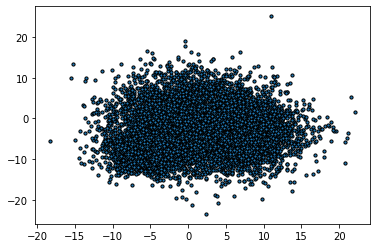

In [845]:
plt.scatter(X[:,0], X[:,1], s=10, edgecolor='k')

gloom...

Okay. Let's see the projections on the first two axes.

In [846]:
# make a color map
color_map = dict(zip([0,1,2,3], ["red", "blue", "green", "yellow"]))

{<matplotlib.collections.PathCollection at 0x7f55714dfa90>,
 <matplotlib.collections.PathCollection at 0x7f55714fcf90>}

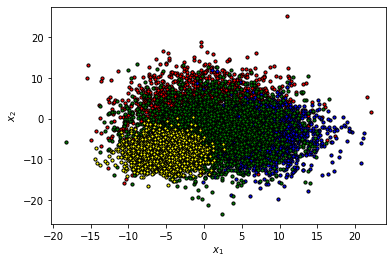

In [847]:
# draw original set by using simple for comprehension
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
{plt.scatter(X[y == k, 0], X[y == k, 1], c=v, s=10, edgecolor='k') for (k,v) in color_map.items()}   

Nice! Now let's see what we have with clustering

In [848]:
from sklearn.cluster import KMeans

In [849]:
#Set a 4 KMeans clustering
kmeans_test = KMeans(n_clusters = 4)

In [850]:
#Compute cluster centers and predict cluster indices
X_test = kmeans_test.fit_predict(X)

In [851]:
import numpy as np
# make a color map for predicted cluster indices
kmeans_color_map = dict(zip(np.unique(kmeans_test.labels_), ["red", "blue", "green", "yellow"]))

{<matplotlib.collections.PathCollection at 0x7f557146efd0>,
 <matplotlib.collections.PathCollection at 0x7f55714ceb90>}

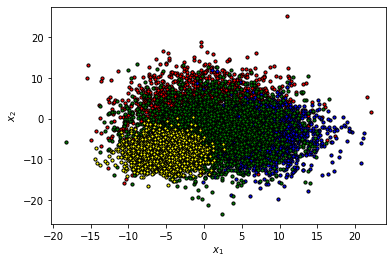

In [852]:
# draw clustered set
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
{plt.scatter(X[y == k, 0], X[y == k, 1], c=v, s=10, edgecolor='k') for (k,v) in kmeans_color_map.items()} 

Ok! What about clustering metrics? Let's see all of them.

In [853]:
from sklearn import metrics

In [854]:
print('ARI: '+str(metrics.adjusted_rand_score(y, kmeans_test.labels_)))
print('AMI: '+str(metrics.adjusted_mutual_info_score(y, kmeans_test.labels_)))
print('Homogenity: '+str(metrics.homogeneity_score(y, kmeans_test.labels_)))
print('Completeness: '+str(metrics.completeness_score(y, kmeans_test.labels_)))
print('V-measure: '+str(metrics.v_measure_score(y, kmeans_test.labels_)))
print('Silhouette: '+str(metrics.silhouette_score(X, kmeans_test.labels_)))

ARI: 0.8244871756050167
AMI: 0.7966143759540111
Homogenity: 0.7961294036284816
Completeness: 0.7972322989538199
V-measure: 0.7966804695893386
Silhouette: 0.32688315686950803


For more info you can use [7 topic of ODS Course](https://www.kaggle.com/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering).

Russian version of the article [here](https://habr.com/company/ods/blog/325654/)

Now let's check how much components have influence in terms of explained variance. The [article](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#explained-variance) can help you to realize the concept of explained variance. Here is the support function below: for plotting ` explained variance/principle components` flat. 

In [855]:
# survice function for Explained variance ratio plotting
def plot_explained_variance(X):
    #Calculating Eigenvecors and eigenvalues of Covariance matrix
    mean_vec = np.mean(X, axis=0)
    cov_mat = np.cov(X.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    print(var_exp)
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
    print(cum_var_exp)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')

To use it properly it would be better to use [Feature Scaling](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)
by using `StandardScaler` from the `sklearn` preprocessing.

In [856]:
from sklearn.preprocessing import StandardScaler

[41.08052894804806, 23.350140404817175, 17.877280836181107, 11.057597238818305, 6.63445257213534]
[ 41.08052895  64.43066935  82.30795019  93.36554743 100.        ]


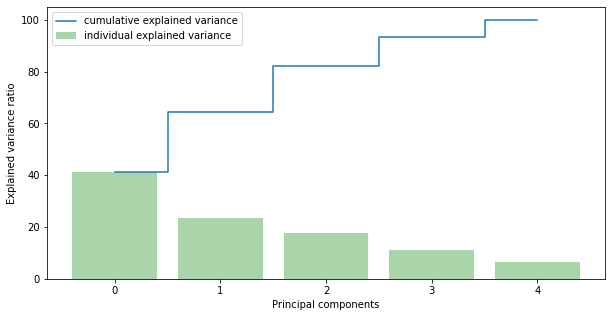

In [857]:
X_std = StandardScaler().fit_transform(X)
plot_explained_variance(X_std)

The plot above clearly shows that most of the variance can be explained by the 4 first principal components. But to see more in detail, let's look at the correlation matrix. To do this, we first wrap the data in the `DataFrame` (`pandas` module) and then use the `heatmap` from `seaborn` module.

In [858]:
import seaborn as sns
import pandas as pd

In [859]:
columns = ['feature_' + str(x) for x in np.arange(1, 7, 1)]
d = {key: values for key, values in zip(columns, X.T)}
data = pd.DataFrame(d)

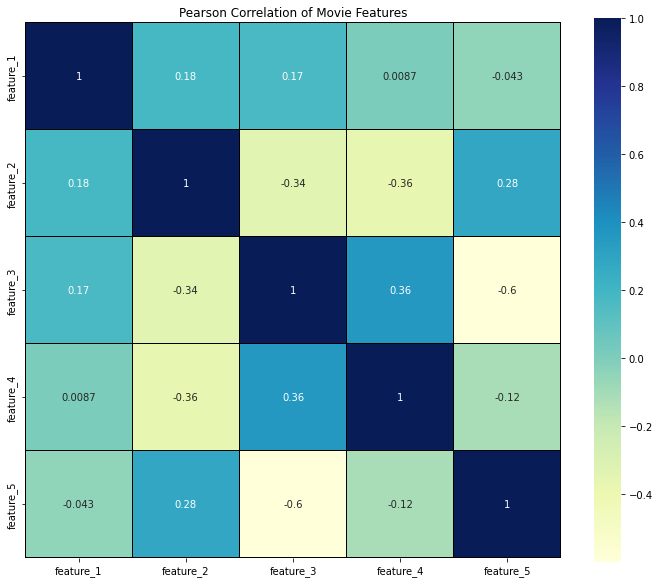

In [860]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Movie Features')
sns.heatmap(data.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

So, it's time to use PCA. Let's try it with 4 components and and see what happens

In [861]:
from sklearn.decomposition import PCA

In [862]:
pca = PCA(n_components=4)
X_transformed = pca.fit_transform(X_std)

{<matplotlib.collections.PathCollection at 0x7f5571263250>,
 <matplotlib.collections.PathCollection at 0x7f55712d1a50>}

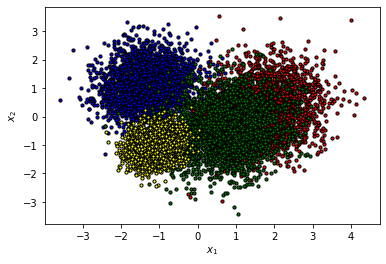

In [863]:
# draw transformed set using simple for comprehension
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
{plt.scatter(X_transformed[y == k, 0], X_transformed[y == k, 1], c=v, s=10, edgecolor='k') for (k,v) in color_map.items()} 

In [864]:
#Set a 4 KMeans clustering
kmeans = KMeans(n_clusters = 4)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_transformed)

print('ARI: '+str(metrics.adjusted_rand_score(y, kmeans.labels_)))
print('AMI: '+str(metrics.adjusted_mutual_info_score(y, kmeans.labels_)))
print('Homogenity: '+str(metrics.homogeneity_score(y, kmeans.labels_)))
print('Completeness: '+str(metrics.completeness_score(y, kmeans.labels_)))
print('V-measure: '+str(metrics.v_measure_score(y, kmeans.labels_)))
print('Silhouette: '+str(metrics.silhouette_score(X, kmeans.labels_)))

ARI: 0.8038136447974721
AMI: 0.7751468352738459
Homogenity: 0.7744685115770219
Completeness: 0.7759727989417124
V-measure: 0.7752199255056962
Silhouette: 0.32464042128302373


It is obvious that there was a loss of information and the quality of clustering has greatly decreased. Try to explain this fact.

### Task 1: Explain why in the example above there was a loss of information

In [865]:
# YOUR ANSER HERE
# 4 components cover 93.36554743% of variance, thus losing roughly 6.64% of variance. 
# In exchange of reducing dimensionality we sacrificed that variance, thus inducing the information loss

## Case 2: A Synthetic Example

A synthetic example contains 10 features, each of which is a simple linear combination of three values: $V1, V2, V3$

$$V_1 \sim N(0, 290)$$
$$V_2 \sim N (0, 300)$$
$$V_3 = −0.3 V_1 + 0.925 V_2 + \epsilon, \ \epsilon \sim N(0, 1)$$

You need to find out how much of this data set has the main components, and compare the speed of your PCA implementation (SPCA) and the implementation of the library version.

In [866]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [867]:
# The first column contains numbers, so we'll drop it away

df = pd.read_csv("./synthetic.csv").drop(['Unnamed: 0'], axis=1)

In [868]:
df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-10.300572,-10.223979,-10.261041,-10.298542,-0.907981,-0.871749,-0.858199,-0.869117,2.260210,2.295032
std,290.351225,290.416600,290.447987,290.348275,309.676982,309.679532,309.688980,309.690409,299.690438,299.702929
min,-948.785544,-947.426298,-948.183414,-946.103105,-1050.600486,-1051.590743,-1050.689972,-1052.534237,-981.237523,-979.918814
25%,-208.860156,-207.994619,-208.985917,-209.224097,-215.534522,-215.677995,-215.109818,-215.932351,-209.935685,-208.212333
50%,-13.685264,-12.584181,-12.327687,-12.678418,-0.357133,-0.382485,-0.838992,-0.416611,-0.037262,0.181423
75%,184.409977,185.553442,185.341876,186.585310,213.547165,214.285983,214.444783,214.724167,192.580681,193.193607
max,967.447551,965.439510,965.476957,965.163611,1006.274708,1005.816135,1005.048558,1006.008403,920.426604,919.275054


[60.07584141303206, 39.92310484137326, 0.00027513012822329684, 0.0001330273814363377, 0.00012370447597180245, 0.00011665923925268674, 0.00011002412210714338, 0.00010206632431245583, 9.786149549352097e-05, 9.527242788713431e-05]
[ 60.07584141  99.99894625  99.99922138  99.99935441  99.99947812
  99.99959478  99.9997048   99.99980687  99.99990473 100.        ]


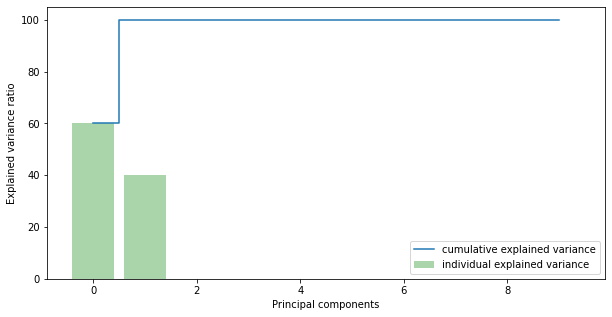

In [869]:
# Do not forget to use the scaling
X_std = StandardScaler().fit_transform(df.values)

# Determine the number of main components.
plot_explained_variance(X_std)
# YOUR CODE HERE




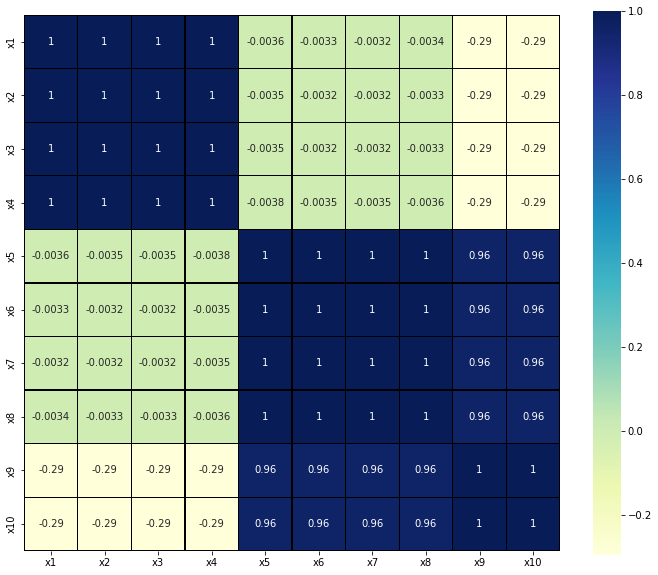

In [870]:
# Check the covariation matrix by using sns.heatmap(...) (optionally)
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)
# YOUR CODE HERE


We will test your hypothesis and measure the running time of the library versions of the algorithms

In [871]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

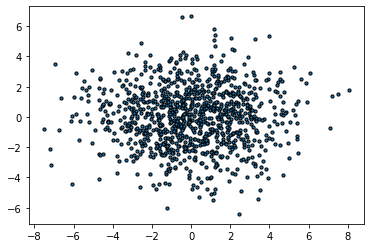

In [872]:
pca = PCA(n_components=2)
x_d = pca.fit_transform(X_std)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

In [873]:
%timeit pca.fit_transform(X_std)

The slowest run took 4.25 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 1.96 ms per loop


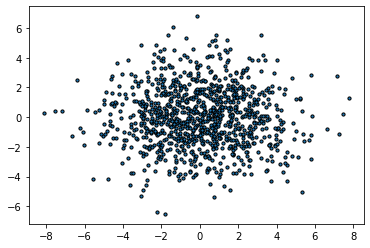

In [874]:
spca = SparsePCA(n_components=2)
x_d = spca.fit_transform(X_std)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

In [875]:
%timeit spca.fit_transform(X_std)

10 loops, best of 5: 151 ms per loop


### Task 2: Implement you version of PCA (or SPCA) and using template above check it time performance

In [876]:
import math as m
from random import normalvariate
from math import sqrt
import numpy as np

#### PCA

In [877]:
# YOUR IMPLEMENTATION OF PCA (FOR NOVICES)
class myPCA():
  def __init__(self, n_components=None):
    self.n_components = n_components
    self.eps = 1e-15

  def randomUnitVector(self, n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]    
    theNorm = sqrt(sum(x * x for x in unnormalized))  
    return [x / theNorm for x in unnormalized]

  def norm(self, X):
    X_2 = X ** 2
    return sqrt(np.sum(X_2))

  def svd_1d(self, A):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = self.randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
      B = np.dot(A.T, A)
    else:
      B = np.dot(A, A.T)

    iterations = 0
    while True:
      lastV = currentV
      currentV = np.dot(B, lastV)
      currentV = currentV / self.norm(currentV)

      if abs(np.dot(currentV, lastV)) > 1 - self.eps:
        return currentV


  def svd(self, A):
      '''
          Compute the singular value decomposition of a matrix A
          using the power method. A is the input matrix, and k
          is the number of singular values you wish to compute.
          If k is None, this computes the full-rank decomposition.
      '''
      n, m = A.shape
      svd = []
      k = min(n, m)

      for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svd[:i]:
          matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
          v = self.svd_1d(matrixFor1D)
          u_unnormalized = np.dot(A, v)
          sigma = self.norm(u_unnormalized)
          u = u_unnormalized / sigma
        else:
          u = self.svd_1d(matrixFor1D)
          v_unnormalized = np.dot(A.T, u)
          sigma = self.norm(v_unnormalized)
          v = v_unnormalized / sigma

        svd.append((sigma, u, v))

      singularValues, us, vs = [np.array(x) for x in zip(*svd)]
      return singularValues, us.T, vs          
  def fit_transform(self, X, y=None):
    s, U, Vt = self.svd(X)
    U = U[:, : self.n_components]    
    U *= s[: self.n_components]
    return U

In [878]:
u, s, v = np.linalg.svd(X_std, full_matrices=False)
pca = myPCA(2)
values, left_s, rigth_s = pca.svd(X_std)

print(u)
print('HI')
print(left_s)

[[-0.01467326  0.03791522 -0.03548796 ... -0.00558798  0.00099286
   0.04130992]
 [-0.04159245 -0.04388505  0.02153303 ... -0.02744744  0.0408227
  -0.048882  ]
 [ 0.03718582  0.02694043 -0.00431479 ... -0.02819432 -0.00681274
  -0.02479492]
 ...
 [-0.003063   -0.04869221 -0.01385942 ... -0.03080241 -0.02836305
   0.03201542]
 [-0.04237279 -0.02386942 -0.02383249 ...  0.02670394 -0.03292613
  -0.02775487]
 [-0.00424747  0.00585546 -0.03828395 ...  0.03475568 -0.00928424
  -0.01380326]]
HI
[[-0.01467326  0.03791522  0.03548796 ...  0.00558797 -0.00099292
  -0.04130992]
 [-0.04159245 -0.04388504 -0.02153303 ...  0.02744748 -0.04082259
   0.04888207]
 [ 0.03718582  0.02694043  0.00431479 ...  0.02819431  0.00681282
   0.02479491]
 ...
 [-0.003063   -0.04869221  0.01385942 ...  0.0308024   0.02836303
  -0.03201547]
 [-0.04237279 -0.02386942  0.02383249 ... -0.02670399  0.03292615
   0.02775481]
 [-0.00424747  0.00585546  0.03828396 ... -0.03475568  0.00928422
   0.01380324]]


In [879]:
pca = PCA(n_components=2)
x_d1 = pca.fit_transform(X_std)
#######################################
pca = myPCA(n_components=2)
x_d = pca.fit_transform(X_std)

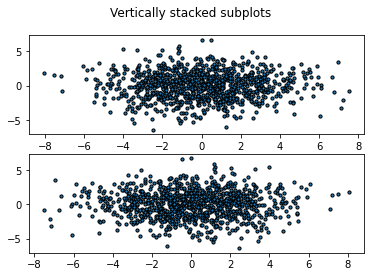

In [880]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')
axs[1].scatter(x_d1[:,0],x_d1[:,1], s=10, edgecolor='k')

In [881]:
# TEST TIME PERFORMANCE OF YOUR PCA
%timeit pca.fit_transform(X_std)

10 loops, best of 5: 40.3 ms per loop


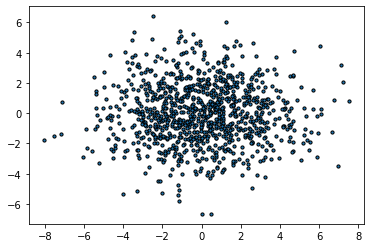

In [882]:
# DRAW RESULTS
x_d = pca.fit_transform(X_std)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

#### SparcePCA (for champions)

In [883]:
# # YOUR IMPLEMENTATION OF SparcePCA (FOR CHAMPIONS)
# class mySparcePCA():
#     def __init__(self, n_components=None):
#         # YOUR CODE HERE
#     def fit_transform(self, X, y=None):
#         # YOUR CODE HERE

In [884]:
# spca = mySparcePCA(n_components=???)  

In [885]:
# # TEST TIME PERFORMANCE OF YOUR SPCA
# %timeit spca.fit_transform(X_std)

In [886]:
# # DRAW RESULTS
# x_d = spca.fit_transform(X_std)
# plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

## Case 3: Сreative task

I offer your to have a practive with your implementation on [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata) Kaggle dataset. 

You need to identify the number of main components and make clustering using Kmeans.

- Preliminary preparation of the dataset: get rid of zero values, transform categorical features.

- Scale the dataset (use StandardScaler or anything you want).

- Identify the number of main components (demonstrate the analysis toolkit).

- Reduce the dimensionality of the space by using your PCA implementation (SPCA).

- Cluster the dataset by Kmeans algo.

In [887]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [888]:
df = pd.read_csv("./tmdb_5000_movies.csv")

In [889]:
df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [890]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

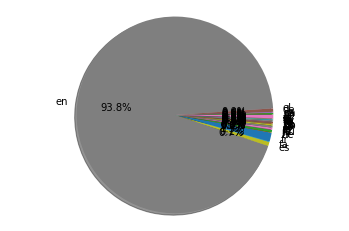

In [891]:
labels = df['original_language'].astype('category').cat.categories.tolist()
counts = df['original_language'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

In [892]:
print(len(labels))
for i in range(len(labels)):
  print(sizes[i], labels[i])

37
1 af
2 ar
12 cn
2 cs
7 da
27 de
1 el
4505 en
32 es
4 fa
70 fr
3 he
19 hi
1 hu
2 id
1 is
14 it
16 ja
11 ko
1 ky
1 nb
4 nl
1 no
1 pl
1 ps
9 pt
2 ro
11 ru
1 sl
5 sv
2 ta
1 te
3 th
1 tr
1 vi
1 xx
27 zh


In [893]:
df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [894]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [895]:
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [896]:
# df_onehot = df.copy()
# df_onehot = pd.get_dummies(df_onehot, columns=['status', 'original_language'], prefix = ['status', 'original_language'])
#Using binary instead

In [897]:
!pip install category_encoders

In [898]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['status', 'original_language'])
df_binary = encoder.fit_transform(df)

df_binary.head()

,budget,genres,homepage,id,keywords,original_language_0,original_language_1,original_language_2,original_language_3,original_language_4,original_language_5,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status_0,status_1,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",0,0,0,0,0,1,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",0,1,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",0,0,0,0,0,1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",0,1,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",0,0,0,0,0,1,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",0,1,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",0,0,0,0,0,1,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",0,1,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",0,0,0,0,0,1,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",0,1,"Lost in our world, found in another.",John Carter,6.1,2124


In [899]:
df_binary = df_binary.select_dtypes(exclude=[object])

In [900]:
df_binary.fillna(df_binary.mean(), inplace = True)

In [901]:
df_binary.isnull().sum()

budget                 0
id                     0
original_language_0    0
original_language_1    0
original_language_2    0
original_language_3    0
original_language_4    0
original_language_5    0
popularity             0
revenue                0
runtime                0
status_0               0
status_1               0
vote_average           0
vote_count             0
dtype: int64

In [902]:
df_binary.head()

,budget,id,original_language_0,original_language_1,original_language_2,original_language_3,original_language_4,original_language_5,popularity,revenue,runtime,status_0,status_1,vote_average,vote_count
0,237000000,19995,0,0,0,0,0,1,150.437577,2787965087,162.0,0,1,7.2,11800
1,300000000,285,0,0,0,0,0,1,139.082615,961000000,169.0,0,1,6.9,4500
2,245000000,206647,0,0,0,0,0,1,107.376788,880674609,148.0,0,1,6.3,4466
3,250000000,49026,0,0,0,0,0,1,112.312950,1084939099,165.0,0,1,7.6,9106
4,260000000,49529,0,0,0,0,0,1,43.926995,284139100,132.0,0,1,6.1,2124


In [903]:
len(df_binary.columns)

15

[22.13726472885671, 14.939385548768502, 10.853847513836373, 8.759613002474417, 6.8364125433939975, 5.927799633291097, 5.402724684078965, 4.967821833958505, 4.802154023563184, 4.590120043030669, 2.7427176835372324, 2.705209518499132, 2.5572124078122296, 1.7139728530626743, 1.0637439818363013]
[ 22.13726473  37.07665028  47.93049779  56.69011079  63.52652334
  69.45432297  74.85704765  79.82486949  84.62702351  89.21714356
  91.95986124  94.66507076  97.22228317  98.93625602 100.        ]


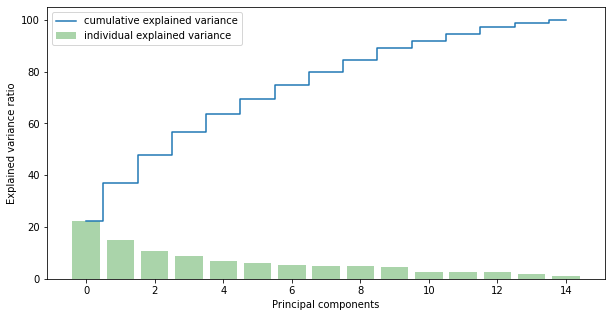

In [904]:
# Do not forget to use the scaling
X_std = StandardScaler().fit_transform(df_binary.values)

# Determine the number of main components.
plot_explained_variance(X_std)
# YOUR CODE HERE

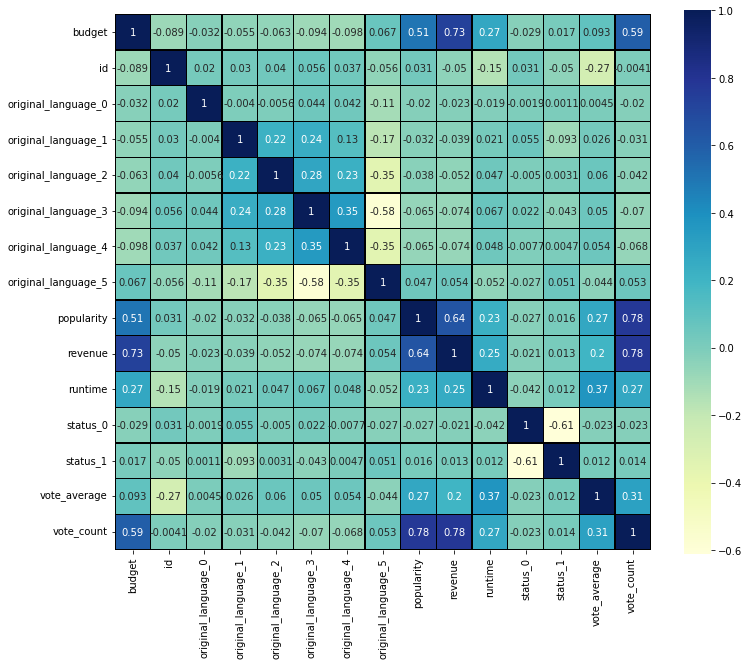

In [905]:
# Check the covariation matrix by using sns.heatmap(...) (optionally)
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df_binary.corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

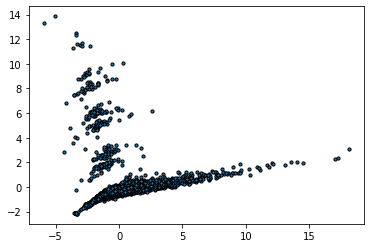

In [906]:
pca = PCA(n_components=8)
x_d = pca.fit_transform(X_std)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

In [907]:
#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_d)

LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

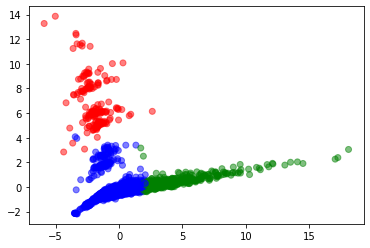

In [908]:
plt.scatter(x_d[:,0],x_d[:,1], c= label_color, alpha=0.5)

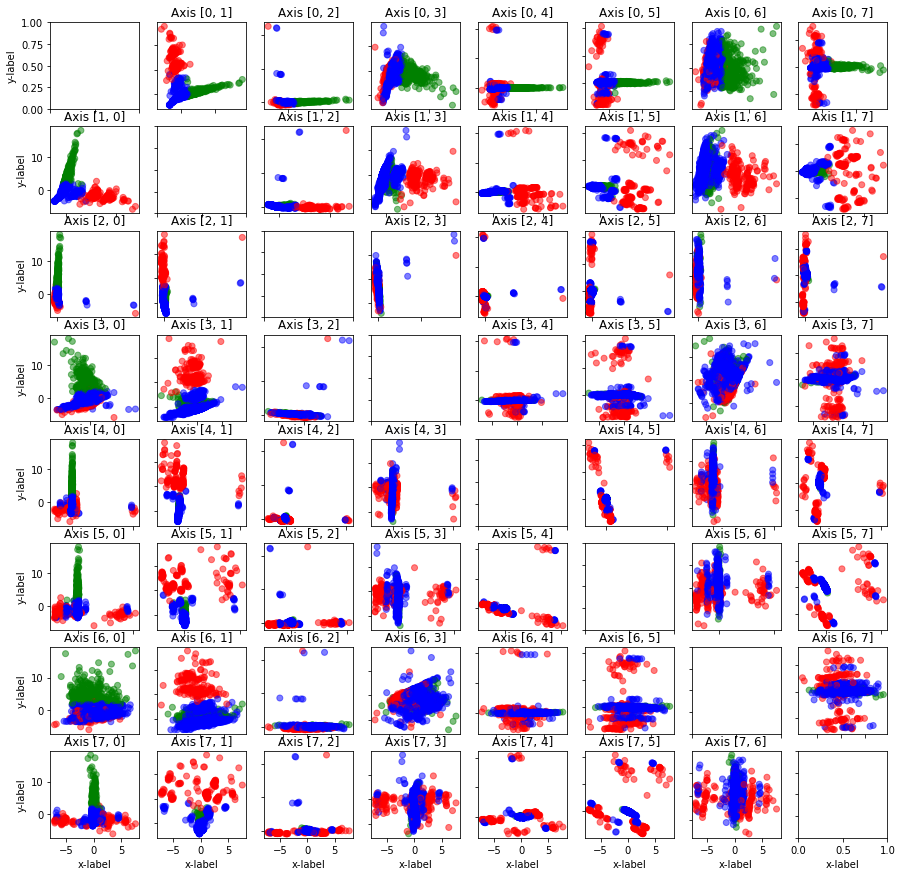

In [909]:
fig, axs = plt.subplots(8, 8, figsize=(15,15))
for i in range(8):
  for j in range(8):
#    checking all componenets pairwise for visualization
    if i == j:      
      continue  
    axs[i, j].scatter(x_d[:,i],x_d[:,j], c= label_color, alpha=0.5)
    axs[i, j].set_title('Axis [{}, {}]'.format(i, j))
      
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()